In [1]:
import dl
import numpy as np
from tensorflow.keras.datasets import mnist
import cv2
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Load and view data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

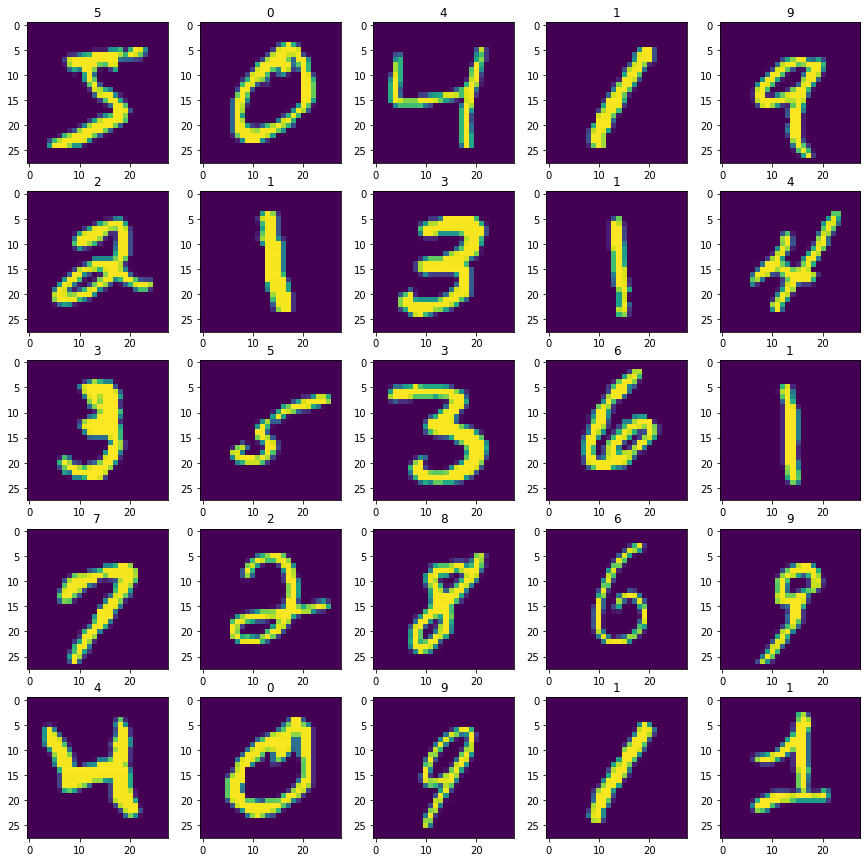

In [3]:
fig = plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.title(f'{y_train[i]}')
    plt.imshow(x_train[i])
plt.show()

### t-SNE: t-Distributed Stochastic Neighbor Embedding
A way to visualize higher dimensional data! We can get an idea of how data is clustered in high dimensions by viewing clusters in low dimensions. We can clearly see clusters below. 

In [4]:
x = x_train[:1000].reshape((1000, 784))
tSNE_model = TSNE(n_components=2, random_state=0)
x2D = tSNE_model.fit_transform(x)
target_ids = range(10)
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
target_names = '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'

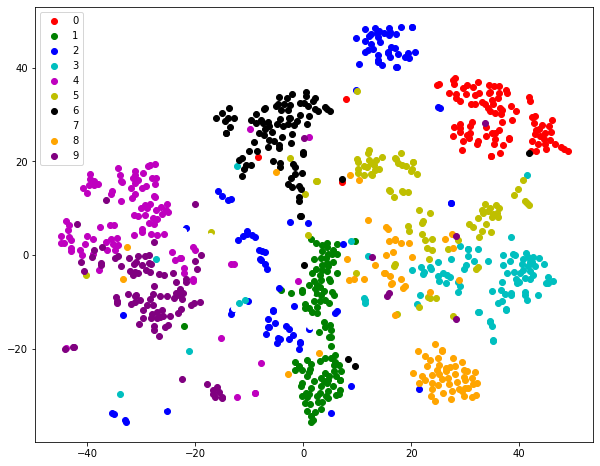

In [5]:
plt.figure(figsize=(10, 8))
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(x2D[y_train[:1000] == i, 0], x2D[y_train[:1000] == i, 1], c=c, label=label)
plt.legend()
plt.show()

### Initialize, train and test

In [6]:
x_train, x_test = x_train.reshape((60000, 784)) / 255.0, x_test.reshape((10000, 784)) / 255.0
y_train, y_test = dl.onehot(y_train, 10), dl.onehot(y_test, 10)

In [7]:
model = dl.Model([784, 50, 40, 10], ['none', 'relu', 'relu', 'softmax'])
model.comp('ce', dl.Adam((model.W, model.B), 3e-4, 0.99))
errors, losses = model.fit((x_train, y_train), epochs=5)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:22<00:00, 64.52s/it]


In [8]:
print('accuracy:', dl.accuracy(model, x_test, y_test))

accuracy: 96.53


In [9]:
def process(loc, lim):
    img = cv2.imread(loc)
    processed_img = cv2.resize(cv2.imread(loc, 0), dsize=(28, 28)) / 255.0
    for i in range(28):
        for j in range(28):
            processed_img[i][j] = int(processed_img[i][j] < lim)
    fig = plt.figure(figsize=(7, 7))
    plt.subplot(1, 2, 1)
    plt.title('original')
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img)
    plt.title('processed')
    plt.show()
    return processed_img.reshape((784))

In [10]:
def test(loc, lim):
    print('prediction - ', np.argmax(model.forward(process(loc, lim))))

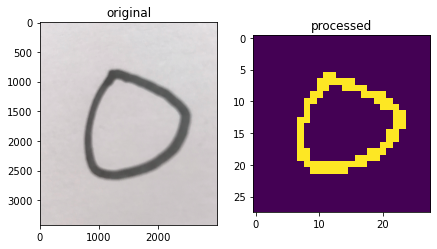

prediction -  0


In [11]:
test('C:/Users/rgbka/Desktop/digits/zero.jpg', 0.7)

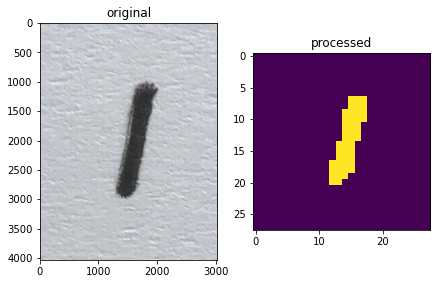

prediction -  1


In [12]:
test('C:/Users/rgbka/Desktop/digits/one.jpg', 0.6)

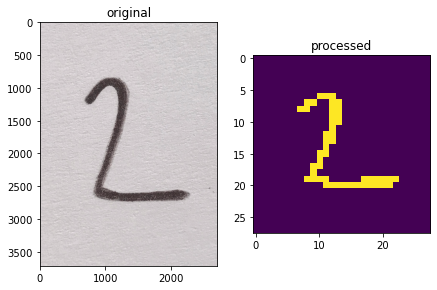

prediction -  2


In [13]:
test('C:/Users/rgbka/Desktop/digits/two.jpg', 0.7)

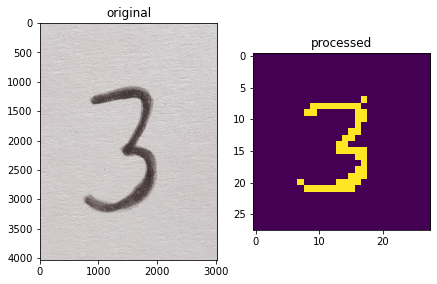

prediction -  1


In [14]:
test('C:/Users/rgbka/Desktop/digits/three.jpg', 0.7)

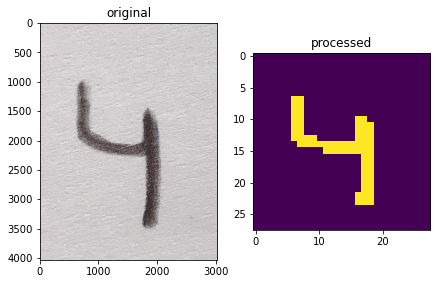

prediction -  4


In [15]:
test('C:/Users/rgbka/Desktop/digits/four.jpg', 0.7)

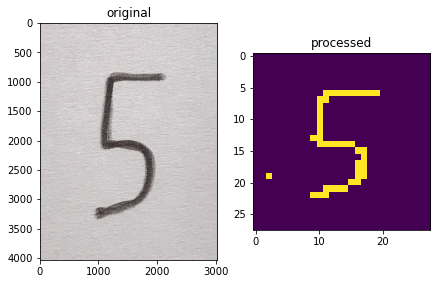

prediction -  5


In [16]:
test('C:/Users/rgbka/Desktop/digits/five.jpg', 0.7)

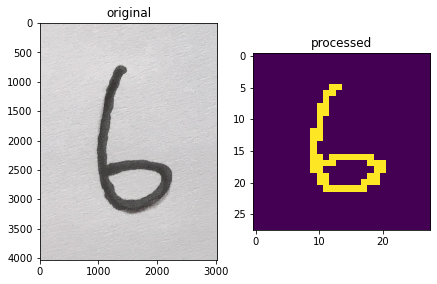

prediction -  6


In [17]:
test('C:/Users/rgbka/Desktop/digits/six.jpg', 0.6)

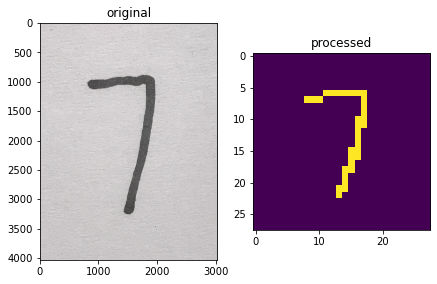

prediction -  7


In [18]:
test('C:/Users/rgbka/Desktop/digits/seven.jpg', 0.7)

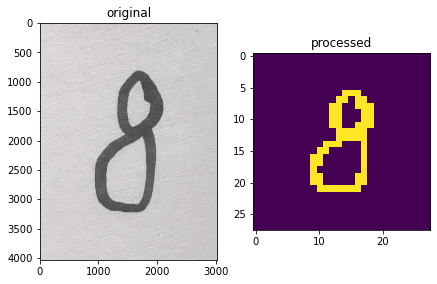

prediction -  8


In [19]:
test('C:/Users/rgbka/Desktop/digits/eight.jpg', 0.6)

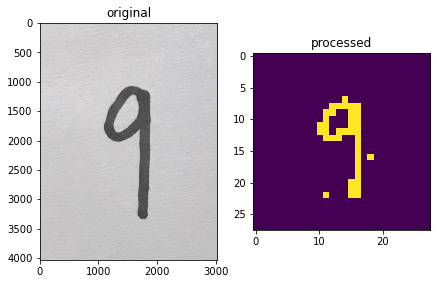

prediction -  4


In [20]:
test('C:/Users/rgbka/Desktop/digits/nine.jpg', 0.7)